# **FIS Group Project - A.Y. 2020/2021**

## **Students**:
### Zanotti Federico - 2007716 - federico.zanotti@studenti.unipd.it
#### The project was realized toghether with other two colleagues, but to preserve personal information I do not mention them except for their names: Arghavan and Federico

#### In particular the **Point 1** was realized by my colleague Federico, the **Point 2** by Arghavan, and the **Point 3** by Zanotti Federico



## Import libraries

In [1]:
import ipywidgets as widgets
import time
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import csv
from IPython.display import clear_output
from datetime import datetime
from ipywidgets import GridspecLayout, Layout
from PIL import Image
import requests
from io import BytesIO
import urllib

## Retrieve Dataset from url



In [2]:
def create_datastructures():
  url = "http://www.dei.unipd.it/~silvello/FIS2020/fifa19.csv"
  df_data = pd.read_csv(url)
  return df_data

In [12]:
fifa19_dataset = create_datastructures()
fifa19_dataset.head()


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# ***Point 1***  of the Project:
An interactive application that takes two-player names as input and produces a visualization to compare their attributes. The visualization can be interactive. 

In [ ]:
raw_data_1 = fifa19_dataset.copy()
raw_data_1 = raw_data_1.set_index(raw_data_1.loc[:, 'ID'])
raw_data_1 = raw_data_1.drop(['Unnamed: 0', 'ID'], axis=1)
raw_data_1.head()

## Photos: URL-generating and scraping functions

#### Given the player ID, we were able to build URLs for player and club photos (URLs provided in the dataset are no longer valid) and scrape the SoFifa website using a fairly simple scraping function 

In [ ]:
def create_photo_url_series(data):
    l = {}
    for i in data.index:
        a = str(i)
        buffer = ''
        if len(a) < 6:
            while (len(a) + len(buffer)) < 6:
                buffer = buffer + '0'
            url_plug = buffer + a
            url_plug = url_plug[:3] + '/' + url_plug[3:] +'/'
        else:
            url_plug = a[:3] + '/' + a[3:] + '/'
            
        l[i] = 'https://cdn.sofifa.com/players/' + url_plug + '19_120.png'

    return pd.Series(l)


def find_club_id(text):
    l = len(text)
    i = 5
    
    while text[-i] != r'/':
        i += 1
        
    return text[-i+1: -4]


def create_clublogo_url_series(data):
    d = {}
    
    for i in data.index:
        d[data.loc[i, 'Club']] = d.get(data.loc[i, 'Club'], find_club_id(data.loc[i, 'Club Logo']))
    
    for club in d.keys():
        d[club] = 'https://cdn.sofifa.com/teams/' + d[club] + '/120.png'

    return pd.Series(d)


def load_picture(url):
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers = {'User-Agent': user_agent,}
    request = urllib.request.Request(url,None,headers)
    file = urllib.request.urlopen(request)
    img = file.read()

    return img

## Data selection
#### We decided to only include for comparison only meaningful attributes. We removed photos and other features that are only used for in-game dynamics but cannot be compared effectively (Body Type, changes to Overall when the players is used out of position in the game, etc)

In [ ]:
drop_cols_1 = ['Photo', 'Flag', 'Club Logo','Body Type', 'Real Face',
               'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
             'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Special']

In [ ]:
comparable_data_1 = raw_data_1.drop(drop_cols_1, axis=1)

In [ ]:
comparable_data_1

## User Interface (Jupyter is recommended, there are perfomance issues on CoLab with this library)
#### We tried to make an interface similar to FIFA's in-game player comparison.
#### We started by creating a radar chart by grouping into 6 macro-attributes. The dictionary below contains matches to each macro-attribute all the basic attributes and attaches a weight to them (source: https://www.fifauteam.com/fifa-20-attributes-guide/)
#### The graph is created with Matplot, saved in RAM as a png file and loaded as an IPywidgets Image (the example below refers to Messi (blue) vs C. Ronaldo (red). 

In [ ]:
attribute_master_1 = {'Pace' : [('Acceleration', 0.45), ('SprintSpeed', 0.55)],
                        
                        'Shooting': [('Finishing', 0.45), ('Volleys', 0.05), ('ShotPower', 0.2),
                                     ('LongShots', 0.2), ('Positioning', 0.05), ('Penalties', 0.05)],
                        
                        'Dribbling': [('Agility', 0.1), ('Balance', 0.05), ('BallControl', 0.35),
                                      ('Composure', 0), ('Dribbling', 0.50), ('Reactions', 0)],
                        
                        'Defending': [('HeadingAccuracy', 0.1), ('Interceptions', 0.2), ('Marking', 0.3),
                                      ('SlidingTackle', 0.1), ('StandingTackle', 0.3)],
                        
                        'Passing': [('Crossing', 0.2), ('Curve', 0.05), ('FKAccuracy', 0.05),
                                    ('LongPassing', 0.15), ('ShortPassing', 0.35), ('Vision', 0.25)],
                        
                        'Physical': [('Aggression', 0.2), ('Jumping', 0.05), ('Stamina', 0.25), ('Strength', 0.5)]
                       }

In [ ]:
def create_skill_dataframe(dataset, attribute_master, id1, id2):
    data = pd.DataFrame(index=[id1, id2], columns=attribute_master.keys())

    for player in data.index:
        for category in data.columns:
            category_score = 0
            for attribute in attribute_master[category]:
                category_score += dataset.loc[player, attribute[0]] * attribute[1]
                data.loc[player, category] = category_score

    return data


def create_skill_radar(dataset, skill_dataframe):
    matplotlib.rcParams.font_size = 20
    angles=[]
    for n in range(6):
        angles.append((n/6)*np.pi*2)
    angles.append(angles[0])

    categories = skill_dataframe.columns

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60,80], ['20','40','60','80'], color='grey', size=16)
    plt.ylim(0,100)

    values = skill_dataframe.iloc[0].values.tolist()
    values.append(values[0])

    ax.plot(angles, values, 'royalblue', linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'royalblue', alpha=0.1)

    values = skill_dataframe.iloc[1].values.tolist()
    values.append(values[0])
    ax.plot(angles, values, 'tomato',linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'tomato', alpha=0.1)
    
    fig = BytesIO()
    plt.savefig(fig, format='png')
    
    return fig


def radar_widget(radar_io):
    radar_io.seek(0)
    my_radar  = widgets.Image(value=radar_io.read(), format='png', layout=Layout(max_height='220px', max_width = '33%'))

    return my_radar


def create_radar_widget(dataset, attribute_master, id1, id2):
    skill_df = create_skill_dataframe(dataset, attribute_master, id1, id2)
    skill_radar = create_skill_radar(dataset, skill_df)
    widget = radar_widget(skill_radar)
    plt.close()

    return widget

In [ ]:

create_radar_widget(comparable_data_1, attribute_master_1, 158023, 20801)

## Header: Player Tab and Skill Graph
#### The Player Tab features a photo of the player, his club and information about his main position and overall rating. It is created with IPywidgtes Images and Labels using box layouts. It is based on a dedicated DataFrame containing URLs and the relevant information.
##### Text rendering is done with basic LaTex, the integration with the widgets is not very fast, but the library doesn't allow for a more Pythonic option in terms of text formatting

In [ ]:
def create_player_tab_data(raw_data):
    df = raw_data[['Name', 'Overall', 'Position']].copy()
    
    df['photo'] = create_photo_url_series(raw_data)
    df['clublogo'] = None
    
    clublogos = create_clublogo_url_series(raw_data)
    
    for i in df.index:
        df.loc[i, 'clublogo'] = clublogos.loc[raw_data.loc[i, 'Club']]
        
    return df

In [ ]:
def create_player_tab_widget_(player_id, player_tab_data):
    pos = widgets.Label(value = r'\(\LARGE \textbf{' + player_tab_data['Position'].loc[player_id] + '}\)',
                             layout = Layout(display = 'flex', justify_content = 'center', height = '33%'))
    
    ovr =  widgets.Label(value = r'\(\LARGE \textbf{' + str(player_tab_data['Overall'].loc[player_id]) + '}\)',
                             layout = Layout(display = 'flex', justify_content = 'center', height = '33%'))
    
    clubpic = widgets.Image(value = load_picture(player_tab_data['clublogo'].loc[player_id]), height = '33%')
    
    _2 = widgets.VBox([pos, ovr, clubpic], layout = Layout(display = 'flex', justify_content = 'center'))
    
    _1 = widgets.Image(value = load_picture(player_tab_data['photo'].loc[player_id]), width = '200px')
    
    return widgets.HBox([_1, _2], layout = Layout(max_height = '210px'))

In [ ]:
def create_header_tab(comparable_data, attribute_master, player_tab_data, id1 = 158023, id2 = 20801):
    tab_1 = create_player_tab_widget_(id1, player_tab_data)
    tab_1.layout.border = '2px solid royalblue'
    tab_2 = create_player_tab_widget_(id2, player_tab_data)
    tab_2.layout.border = '2px solid tomato'
    graph = create_radar_widget(comparable_data, attribute_master, id1, id2)
    
    return widgets.HBox([tab_1, graph, tab_2])

In [ ]:
player_tab_data_1 = create_player_tab_data(raw_data_1)

In [ ]:
matplotlib.rc('font', **{'size': 20})
create_header_tab(comparable_data_1, attribute_master_1, player_tab_data_1)

## Stats
#### The Stats grid is based on the comparable data DataFrame and is built using IPywidgets Labels.
#### In the full interface the grid is kept to a smaller size for better UX on smaller displays. Size of interface is fixed for the same purpose.

In [ ]:
def create_comparable_stats_grid(comparable_data, id1 = 158023, id2 = 20801):
    rows = len(comparable_data.columns)
    
    comparable_stats_grid = GridspecLayout(rows, 3, layout= Layout(width = '1020px'))
    for i in range(rows):
        comparable_stats_grid[i , 1] = widgets.Label(value = comparable_data.columns[i],
                                                    layout = Layout(display = 'flex', justify_content = 'center', border = '2px solid grey', height = '30px'))
        comparable_stats_grid[i , 0] = widgets.Label(value = str(comparable_data[comparable_data.columns[i]].loc[id1]),
                                                    layout = Layout(display = 'flex', justify_content = 'center', border = '2px solid royalblue'))
        comparable_stats_grid[i , 2] = widgets.Label(value = str(comparable_data[comparable_data.columns[i]].loc[id2]),
                                                    layout = Layout(display = 'flex', justify_content = 'center', border = '2px solid tomato'))
        
    return comparable_stats_grid

In [ ]:
create_comparable_stats_grid(comparable_data_1)

## Dropdown Menus
#### Position, Country and Age Selection menus are intended for filtering of the Player Selection List.
#### The Player Selection menu is capped at the 500 best players in terms of overall rating matching the criteria in the previous menus. It would've been too burdensome to have all 18.000 Players in a single menu
#### Dropdown Menus are not interactive in the below example, they are activated in the full interface.

In [ ]:
def pos_select():
    position_list = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
             'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK', 'ALL']

    position_list = position_list[::-1]

    position_selector = widgets.Dropdown(options = position_list,
                               description = 'Position',
                                        layout = Layout(width='330px'))
    
    return position_selector

In [ ]:
def nationality_select(comparable_data):
    nationalities = list(set(comparable_data['Nationality']))
    nationalities.append('ALL')
    nationalities.sort()
    
    selector = widgets.Dropdown(options = nationalities,
                               description = 'Country',
                                layout = Layout(width='330px'))
    
    return selector

In [ ]:
def age_selectors(comparable_data):
    ages = list(set(comparable_data['Age']))
    ages.sort()
    ages_ = ['ALL']
    ages_.extend(ages)
    
    a_min = widgets.Dropdown(options = ages_,
                             description = 'Min. Age',
                                        layout = Layout(width='330px'))
    
    a_max = widgets.Dropdown(options = ages_,
                             description = 'Max. Age',
                                        layout = Layout(width='330px'))
    
    return a_min, a_max

In [ ]:
def player_selector(masked_list):
    sel = widgets.Dropdown(options = [(masked_list['Name'].loc[i], i) for i in masked_list.index[:500]],
                             description = 'Sel. Player',
                                        layout = Layout(width='330px'))
    
    return sel

In [ ]:
def generate_filters(comparable_data):
    position = pos_select()
    nationality = nationality_select(comparable_data)
    a_min, a_max = age_selectors(comparable_data)
    sel = player_selector(comparable_data)
    
    return (position, nationality, a_min, a_max, sel)

In [ ]:
def generate_filter_interface(comparable_data):
    player1_selectors = generate_filters(comparable_data)
    player2_selectors = generate_filters(comparable_data)
    player2_selectors[4].value = 20801
    
    player1_interface = widgets.VBox([player1_selectors[i] for i in range(len(player1_selectors))])
    player2_interface = widgets.VBox([player2_selectors[i] for i in range(len(player2_selectors))])
    
    compare_button = widgets.Button(description = 'Compare',
                                        layout = Layout(width='330px'))
    
    interface = widgets.HBox([player1_interface, compare_button, player2_interface],
                            layout = Layout(align_items = 'flex-end'))
    
    return player1_selectors, player2_selectors, interface, compare_button

In [ ]:
_ = generate_filter_interface(comparable_data_1)

In [ ]:
_[2]

## Interactivity formulas and Interface Generation
#### Remember to click 'Compare' to update the interface

In [ ]:
def update_masked_list_1(change):
    option_list = masked_list_1.copy()
    
    if p1sel_1[0].value != 'ALL':
        option_list = option_list[option_list['Position'] == p1sel_1[0].value]
        
    if p1sel_1[1].value != 'ALL':
        option_list = option_list[option_list['Nationality'] == p1sel_1[1].value]
        
    if (p1sel_1[2].value != 'ALL'):
        option_list = option_list[option_list['Age'] >= p1sel_1[2].value]
        
    if p1sel_1[3].value != 'ALL':
        option_list = option_list[option_list['Age'] <= p1sel_1[3].value]
    
    p1sel_1[4].options = [(option_list['Name'].loc[i], i) for i in option_list.index[:500]]

    
def update_masked_list_2(change):
    option_list = masked_list_1.copy()
    
    if p2sel_1[0].value != 'ALL':
        option_list = option_list[option_list['Position'] == p2sel_1[0].value]
        
    if p2sel_1[1].value != 'ALL':
        option_list = option_list[option_list['Nationality'] == p2sel_1[1].value]
        
    if (p2sel_1[2].value != 'ALL'):
        option_list = option_list[option_list['Age'] >= p2sel_1[2].value]
        
    if p2sel_1[3].value != 'ALL':
        option_list = option_list[option_list['Age'] <= p2sel_1[3].value]
    
    p2sel_1[4].options = [(option_list['Name'].loc[i], i) for i in option_list.index[:500]]
    

In [ ]:
def generate_full_interface(comparable_data, attribute_master, player_tab_data, id1 = 158023, id2 = 20801):
    header = create_header_tab(id1, id2, comparable_data, attribute_master, player_tab_data)
    stats = create_comparable_stats_grid(comparable_data, id1, id2)
    #p1sel, p2sel, filters = generate_filter_interface(comparable_data)
    
    return widgets.VBox([header, stats])

In [ ]:
def update_stats_grid(comparable_data_1, id1, id2, stats_grid):
    for i in range(len(comparable_data_1.columns)):
        stats_grid[i, 0].value = str(comparable_data_1[comparable_data_1.columns[i]].loc[id1])
        stats_grid[i, 2].value = str(comparable_data_1[comparable_data_1.columns[i]].loc[id2])
        
    return stats_grid

In [ ]:
def update_full_interface(change):
    global p1sel_1
    global p2sel_1
    final_grid_1[1,0] = create_header_tab(comparable_data_1, attribute_master_1, player_tab_data_1, p1sel_1[4].value, p2sel_1[4].value)
    final_grid_1[2,0] = update_stats_grid(comparable_data_1, p1sel_1[4].value, p2sel_1[4].value, final_grid_1[2,0])
    
    for i in range(len(p1sel_1)-1):
        p1sel_1[i].observe(update_masked_list_1, names = 'value')
        p2sel_1[i].observe(update_masked_list_2, names = 'value')
    
    p1sel_1[4].observe(update_full_interface, names = 'value')

In [ ]:
masked_list_1 = comparable_data_1.copy()

In [ ]:
final_grid_1 = GridspecLayout(3,1, layout = Layout(display = 'flex', flex_flow = 'column', grid_gap = '30px'))
p1sel_1, p2sel_1, final_grid_1[0,0], compare_button_1 = generate_filter_interface(comparable_data_1)
final_grid_1[1,0] = create_header_tab(comparable_data_1, attribute_master_1, player_tab_data_1)
final_grid_1[2,0] = create_comparable_stats_grid(comparable_data_1)
final_grid_1[2,0].layout.max_height = '400px'

In [ ]:
for i in range(len(p1sel_1)-1):
    p1sel_1[i].observe(update_masked_list_1, names = 'value')
    p2sel_1[i].observe(update_masked_list_2, names = 'value')
    
compare_button_1.on_click(update_full_interface)

## WARNING: to avoid conflict with other interactive parts of this project, run all above cells and the next one! 

In [ ]:
final_grid_1

# ***Point 2***  of the Project:
An application that takes the name of a team as input and produces a visualization comparing the players in terms of an attribute of choice. The attribute can be an input or can be selected interactively. 



## Please run the cells till the part which is called  "The main Part"
## There after running the first cell Please choose a Club Name from dropdown and Then run the second Cell and choose a parameter then you can see the Graph Thank you.

## Cleaning

In [ ]:
# dropping the "unname" column

fifac2= fifa19_dataset.drop('Unnamed: 0',1)
fifac2 = fifac2.drop('ID',1)

In [ ]:
#dropping rows without Club and reseting the index
df2 = fifac2[fifac2['Club'].notna()]
df2=df2.reset_index(drop=True)

In [ ]:
df2.columns

### Omitting signs from columns

#### Value

In [ ]:
print(df2['Value'])
#print(df.dtypes['Value'])

In [ ]:
df2.shape

In [ ]:
df2['Value'] = df2['Value'].str.replace('€', '')

In [ ]:
df20 = df2[~df2["Value"].str.contains("M")]
df20 = df20[~df20["Value"].str.contains("K")]
df20['Value'] = pd.to_numeric(df20['Value'])

In [ ]:

df2k=df2[df2['Value'].str.contains("K")]
df2k['Value'] = df2k['Value'].str.replace('K', '')
df2k['Value'] = pd.to_numeric(df2k['Value'])
#print(df2k['Value'])


In [ ]:
df2M=df2[df2['Value'].str.contains("M")]
df2M['Value'] = df2M['Value'].str.replace('M', '')
df2M['Value'] = pd.to_numeric(df2M['Value'])
df2M['Value'] = df2M['Value']*(10**3)
#print(df2M['Value'])

In [ ]:
df2V=pd.concat([df2k,df2M,df20],axis=0)
df2V.reset_index(drop=True, inplace=True)
df2V.head


#### Wage

In [ ]:
def clean_Wage2(x):
    
    if isinstance(x, str):
        return(x.replace('€', '').replace('K', ''))
    return(x)

In [ ]:

df2V['Wage'] = df2V['Wage'].apply(clean_Wage2).astype('float')
df2V['Wage'] = pd.to_numeric(df2V['Wage'])


In [ ]:
df2V.shape

#### Height

In [ ]:
def clean_Height2(x):
    
    if isinstance(x, str):
        return(x.replace("'", '.'))
    return(x)

In [ ]:
df2V['Height'] = df2V['Height'].apply(clean_Height2).astype('float')
df2V['Height'] = pd.to_numeric(df2V['Height'])
df2V['Height'] = df2V['Height']*30.48

#### Weight

In [ ]:
def clean_Weight2(x):
    
    if isinstance(x, str):
        return(x.replace("lbs", '.'))
    return(x)

In [ ]:
df2V['Weight'] = df2V['Weight'].apply(clean_Weight2).astype('float')
df2V['Weight'] = pd.to_numeric(df2V['Weight'])


In [ ]:
df2V.shape

### Renaming some columns' name and adding units

In [ ]:
df2V=df2V.rename(columns={'Wage':'Wage(K€)', 'Height':'Height(cm)','Weight':'Weight(lbs)'})

### Dividing dataset to numeric and non-numeric columns

### Numerical part

In [ ]:
df2n=df2V.select_dtypes(include=[np.number])
df2n.columns

In [ ]:
df2l=df2V[['Club','Name']]
#df2l

In [ ]:
# The final data set with just numerical parameters
df2nf=pd.concat([df2l,df2n],axis=1).reindex(df2l.index)
#df2nf

#### Making list of columns' name

In [ ]:
#List for Club Selection
clubs_list2 = list(df2nf['Club'])
#print(clubs_list2)

In [ ]:
#list for numerical patameter selection
columns_list2=list(df2n.columns)
print(columns_list2)

## The main Part

### Widget for selecting the Club

In [ ]:
# Selcting a Clube Name by user
from ipywidgets import interact


myvar2 = ''
def show_df2(Club_Name2):
    global myvar2
    myvar2 = Club_Name2
    
    df2f=df2nf[df2nf.Club==Club_Name2]
    
    print(df2f)
    
print('Select a Club( it will take some time ;)) ')
interact(show_df2, Club_Name2 = df2nf['Club'])


### Widget for selecting a Parameter + Plot

In [ ]:
df2f=df2nf[df2nf.Club==myvar2]
df2f
print('Pleas select a parameter:')
from ipywidgets import interact

myvar22 = ''
def show_df2(parameter2):
    global myvar22
    myvar22 = parameter2
    

    df2f2=df2f[['Club','Name',parameter2]]
    df2f2 = df2f2.loc[df2f2[parameter2] != 0]

    minValue2 = df2f2[parameter2].min()
    

    
   
    df2f2.sort_values(by=parameter2).plot(x = "Name", y = parameter2, kind = "bar", figsize = (15,15) ,legend = True, ylim=minValue2)
    
    plt.show()
    
    

interact(show_df2, parameter2 = columns_list2)
print('THANK YOU!')

# ***Point 3***  of the Project:
A visualization (possibly interactive) that compares the top 20 clubs in terms of the average overall value grouped by player position (goalkeeper, defensor, etc.).


## Cleaning and Transform data 

 We remove rows with club and position name = `Na`

In [13]:
def cleaning_data_3(df_data):
  df_copy = df_data.copy()
  df_copy = df_copy.rename(columns={'Unnamed: 0' : 'Index'})

  print("number of rows BEFORE some cleaning: " + 
        str(df_copy.shape[0]))
  #remove rows with team with less than 11 players
  df_only_clubs = df_copy.filter(['Club', 'Index'])
  df_only_clubs_countrows = df_only_clubs.groupby(['Club'],
                                                as_index=False).count()
 
  df_copy = df_copy.dropna(subset=['Position', 'Club'])
  print("number of rows AFTER cleaning Na values in"
        + " club and position "+ str(len(df_copy.index)))
  
  return df_copy



Assign role create the column `Position_name` in order to have an easy way to reference the field position of a player


Source for the name tag: https://coachingamericansoccer.com/tactics-and-teamwork/soccer-positions/



In [14]:
goalkeeper = ['GK', 'G', 'K']
defence = ['RWB', 'LWB', 'RB', 'LB', 'CB', 'CFB', 'RFB', 'LFB',
           'RCB', 'LCB', 'TCB', 'CD','SW', 'OFB', 'OB']
midfield = ['DM', 'LM', 'RM', 'CM', 'AM', 'CHB', 'RHB', 'LHB',
            'HM', 'DM', 'CDM','PM','OM', 'WB', 'WM', 'RCM',
            'LCM', 'RDM','LDM']
attack = ['CF', 'RF', 'LF', 'ST', 'IF', 'RI', 'LI', 'RW', 'LW', 
          'CS', 'RCF', 'LCF', 'TCF', 'WF','SS', 'WS', 'RWS', 'LWS',
          'LS', 'RAM', 'RS', 'CAM', 'LAM']

In [15]:
pd.set_option('mode.chained_assignment', None)

def assign_role(data):
  df = data.copy()
  df['Position_name'] = ''
  df_goalkeeper = df.loc[df["Position"].isin(goalkeeper)]
  df_defence = df.loc[df["Position"].isin(defence)]
  df_midfield = df.loc[df["Position"].isin(midfield)]
  df_attack = df.loc[df["Position"].isin(attack)]

  df_goalkeeper.loc[:, 'Position_name'] = df_goalkeeper['Position_name'].apply(lambda x: 'Goalkeeper')

  df_defence.loc[:, 'Position_name'] = df_defence['Position_name'].apply(lambda x: 'Defensor')
  df_midfield.loc[:, 'Position_name'] = df_midfield['Position_name'].apply(lambda x: 'Midfielder')
  df_attack.loc[:, 'Position_name'] = df_attack['Position_name'].apply(lambda x: 'Forward')
  df = [df_attack,df_goalkeeper, df_defence, df_midfield]
  result = pd.concat(df)

  return result

# assign_role_V2(data)

## Init Data Structure

In [16]:
 
##### INIT #####
data_3 = fifa19_dataset.copy()
data_3 = create_datastructures()
data_3 = cleaning_data_3(data_3)
data_3 = assign_role(data_3) 
################
data_3.head()

number of rows BEFORE some cleaning: 18207
number of rows AFTER cleaning Na values in club and position 17918


,Index,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Position_name
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M,Forward
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M,Forward
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M,Forward
5,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,...,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M,Forward
7,7,176580,L. Suárez,31,https://cdn.sofifa.org/players/4/19/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,91,91,FC Barcelona,...,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,€164M,Forward


## Useful functions:

* *`leaderboard_index`* is an utility function to get a nice visualization of leaderboard index
* *`clubs_overall_mean`* returns a mean of the   overall value of all players. It **doesn't consider** the Position 
* *`clubs_overall_mean_by_position`* returns a tuple:
    * First element is a dataframe with the mean of the overall value of roles  *(defence, attack...)* for every team
    * Second element is a dataframe with the mean of overall value and this considers player position


In [17]:
def leaderboard_index(df):
  df.reset_index(inplace=True, drop=True)
  df.index = df.index +1

In [18]:
def clubs_overall_mean(df):
  df_clubs_overall = df.filter(['Club', 'Overall'])

  df_clubs = df_clubs_overall.groupby(['Club'], as_index=False).mean()
  leaderboard_index(df_clubs)
  return df_clubs




In [19]:
def clubs_overall_mean_by_position(df):
  df_clubs_overall_position = df.filter([ 'Club', 'Overall', 'Position_name' ])
  

  df_clubs_position_mean  = df_clubs_overall_position.groupby(['Club', 'Position_name'], as_index=False).mean()
  df_clubs_position_mean_V2  = df_clubs_position_mean.groupby(['Club'],  as_index=False).mean() 
  df_clubs_position_mean_V2.sort_values('Overall', ascending=False,
                                        inplace = True)
  

  leaderboard_index(df_clubs_position_mean)
  leaderboard_index(df_clubs_position_mean_V2)                                                       
  return df_clubs_position_mean,df_clubs_position_mean_V2  

## Leaderboard of the first 20 club with a **SIMPLE MEAN**

`Simple mean`: mean computed without considering the different fields of the players *(goalkeeper, defence, midfield and attack)*

In [20]:
#### MEAN OF OVERALL VALUE OF EVERY CLUBS ####
data_clubs_mean_V1 = clubs_overall_mean(data_3)
data_clubs_mean_V1.sort_values('Overall', ascending=False, inplace=True)
data_clubs_mean_V1.reset_index(inplace=True,drop=True)

i=20
print("First " + str(i) + " clubs WITH simple mean.\n")
print(data_clubs_mean_V1.sort_values('Overall', ascending=False)[:i])
##############################################



First 20 clubs WITH simple mean.

                   Club    Overall
0              Juventus  82.280000
1                Napoli  80.000000
2                 Inter  79.750000
3           Real Madrid  78.242424
4                 Milan  78.074074
5          FC Barcelona  78.030303
6   Paris Saint-Germain  77.433333
7                  Roma  77.423077
8     Manchester United  77.242424
10           SL Benfica  77.000000
9     FC Bayern München  77.000000
11              Chelsea  76.787879
12      Manchester City  76.727273
13    Tottenham Hotspur  76.696970
14             FC Porto  76.678571
15          Sporting CP  76.133333
16            Liverpool  76.000000
17  Bayer 04 Leverkusen  75.807692
18                Lazio  75.437500
19    Borussia Dortmund  75.333333


## Leaderboard of the first 20 club with a **COMPLEX MEAN**

`Complex mean`: mean that takes takes into account the different fields of the players *(goalkeeper, defence, midfield and attack)*

In [21]:
#### MEAN OF OVERALL VALUE OF EVERY CLUBS 
#### WITH THE CONTRIBUTE OF ATTACK, DEFENCE etc ####


data_fields,data_clubs_mean_V2 = clubs_overall_mean_by_position(data_3)
data_clubs_mean_V2.sort_values('Overall', ascending=False, inplace=True)
data_fields = data_fields.sort_values('Overall', ascending=False)
leaderboard_index(data_clubs_mean_V2)
i=20
print("First " + str(i) + " clubs WITH more complex mean.\n")
print(data_clubs_mean_V2[:i])
#########################################################


First 20 clubs WITH more complex mean.

                   Club    Overall
1              Juventus  82.212500
2                Napoli  79.744048
3                 Inter  79.239286
4           Real Madrid  78.702381
5     Manchester United  78.007323
6                 Milan  77.845833
7          FC Barcelona  77.370455
8   Paris Saint-Germain  77.366667
9                  Roma  77.065476
10    FC Bayern München  76.804167
11    Tottenham Hotspur  76.466270
12           SL Benfica  76.308333
13              Arsenal  76.198810
14              Chelsea  76.111742
15             FC Porto  76.036111
16          Sporting CP  75.978175
17      Manchester City  75.711310
18            Liverpool  75.638889
19      Atlético Madrid  75.215909
20  Bayer 04 Leverkusen  75.197917


## Functions that define some statistics:
1. Mean of every fields (attack, defence,...) of the first 20 top club
1. Average age
1. Nationality
1. Potential growth:
>4.1 Mean of the *potential* value, not overall</br>
>4.2 Gain of positions in case of potential leaderboard</br>

1. The most faithful players


### Point 1

In [22]:
clubs = list(data_clubs_mean_V2['Club'])
clubs_top_20=clubs[:20]
clubs_top_20

['Juventus',
 'Napoli',
 'Inter',
 'Real Madrid',
 'Manchester United',
 'Milan',
 'FC Barcelona',
 'Paris Saint-Germain',
 'Roma',
 'FC Bayern München',
 'Tottenham Hotspur',
 'SL Benfica',
 'Arsenal',
 'Chelsea',
 'FC Porto',
 'Sporting CP',
 'Manchester City',
 'Liverpool',
 'Atlético Madrid',
 'Bayer 04 Leverkusen']

In [23]:
""" POINT 1 """
# here I create a DataFrame of 20 clubs 
# with the overall of their attack, defence etc

data_field_20_club = data_fields.loc[data_fields['Club'].isin(clubs_top_20)]
print("-"*50)
print("first 20 club divided by attack, defence etc:")
print()
print(data_field_20_club)
clubs_to_check = set(data_field_20_club['Club'])

assert sorted(clubs_top_20) == sorted(clubs_to_check)

--------------------------------------------------
first 20 club divided by attack, defence etc:

                     Club Position_name    Overall
1306             Juventus       Forward  84.600000
1262                Inter       Forward  82.600000
1308             Juventus    Midfielder  82.250000
858     FC Bayern München       Forward  81.800000
1503    Manchester United    Goalkeeper  81.666667
...                   ...           ...        ...
2019           SL Benfica    Goalkeeper  72.333333
291   Bayer 04 Leverkusen    Goalkeeper  71.750000
539               Chelsea    Goalkeeper  71.750000
1499      Manchester City    Goalkeeper  69.750000
246       Atlético Madrid       Forward  69.500000

[80 rows x 3 columns]


### Point 2. Leaderboard of the top 20 clubs ordered by the average age of the players

In [24]:
""" POINT 2 """
def top20_clubs_age():
  df_clubs_age = data_3.filter(['Club', 'Age'])
  df_top20_clubs_age = df_clubs_age.loc[df_clubs_age['Club'].isin(clubs_top_20)]

  df_top20_clubs_age_mean = df_top20_clubs_age.groupby(['Club'], as_index=False).mean()
  df_top20_clubs_age_mean.sort_values('Age', ascending=False, inplace = True)
  #print(df_top20_clubs_age_mean.loc[df_top20_clubs_age_mean['Club']=='Inter'])
  #print(len(df_top20_clubs_age_mean.index)) # should be 20 
  leaderboard_index(df_top20_clubs_age_mean)
  return df_top20_clubs_age_mean

top20_clubs_age()

,Club,Age
1,Inter,27.458333
2,Juventus,27.160000
3,Sporting CP,26.133333
4,Napoli,25.920000
5,Roma,25.653846
6,Chelsea,25.212121
7,Milan,25.000000
8,FC Porto,24.964286
9,Manchester United,24.757576
10,Arsenal,24.606061


### Point 3. Leaderboard of 20 top clubs respects to the max nationality present in the team

In [25]:
""" POINT 3 """
df_clubs_nationality = data_3.filter(['Club', 'Nationality', 'Index'])

df_top20_clubs_nationality = df_clubs_nationality.loc[df_clubs_nationality['Club'].isin(clubs_top_20)]
#### Frequency of nationality players in the first 20 top clubs #####
df = df_top20_clubs_nationality['Nationality'].value_counts(normalize=True)*100
dic_freq_nationality_20top = df.to_dict()
print("Frequency of nationality in the top 20 clubs")
print(dic_freq_nationality_20top)
print('-'*50+'\n')
#####################################################################

#### Frequency of nationality players for each top 20 club ####


df_top20_clubs_nationality_count = df_top20_clubs_nationality.groupby(['Club', 'Nationality'], as_index=False).count()
df_top20_clubs_nationality_count.rename(columns={'Index': 'Num_players'}, inplace=True)
df_top20_clubs_nationality_count.sort_values('Nationality', ascending=False, inplace = True)

df = df_top20_clubs_nationality_count
g = df.groupby(['Club', 'Nationality']).agg({'Num_players' : 'sum'})
g2 = g.groupby(level=0).apply(lambda x:  round(x / x.sum() *100,2))
g2.rename(columns={'Num_players': 'Num_players_perc'}, inplace=True)
# club='Juventus'
# print("percent of "+club)
# print(g2.loc[g2.index.get_level_values('Club')==club])
dic_p = {}
for club in clubs_top_20:
  max_value=g2.loc[g2.index.get_level_values('Club')==club]['Num_players_perc'].max()
  nationality = g2.loc[g2.Num_players_perc==max_value]
  dic_p[club]=[ nationality.index[0][1],max_value]

list(dic_p.values())[0][0]


df_final=pd.DataFrame(columns=['club', 'nationality', 'percent'])
df_final['club']=list(dic_p.keys())
df_final
for club in list(dic_p.keys()):
  df_final['nationality'].loc[df_final.club==club]=dic_p[club][0]
  df_final['percent'].loc[df_final.club==club]=dic_p[club][1]
leaderboard_index(df_final)
df_final

Frequency of nationality in the top 20 clubs
{'Spain': 14.789915966386555, 'England': 10.92436974789916, 'Brazil': 8.907563025210084, 'Italy': 8.907563025210084, 'France': 8.235294117647058, 'Germany': 7.0588235294117645, 'Portugal': 5.378151260504202, 'Argentina': 5.2100840336134455, 'Belgium': 2.689075630252101, 'Croatia': 2.689075630252101, 'Netherlands': 2.689075630252101, 'Uruguay': 1.8487394957983194, 'Poland': 1.3445378151260505, 'Serbia': 1.3445378151260505, 'Colombia': 1.1764705882352942, 'Greece': 1.1764705882352942, 'Wales': 0.8403361344537815, 'Chile': 0.8403361344537815, 'Switzerland': 0.8403361344537815, 'Senegal': 0.6722689075630253, 'Austria': 0.6722689075630253, 'Scotland': 0.6722689075630253, 'Nigeria': 0.6722689075630253, 'Algeria': 0.6722689075630253, 'Sweden': 0.5042016806722689, 'Ghana': 0.5042016806722689, 'Ivory Coast': 0.5042016806722689, 'Bosnia Herzegovina': 0.5042016806722689, 'Cameroon': 0.5042016806722689, 'Czech Republic': 0.5042016806722689, 'United Stat

,club,nationality,percent
1,Juventus,Italy,44.0
2,Napoli,Italy,16.0
3,Inter,Italy,33.33
4,Real Madrid,Spain,57.58
5,Manchester United,Italy,33.33
6,Milan,Italy,48.15
7,FC Barcelona,Spain,51.52
8,Paris Saint-Germain,France,50.0
9,Roma,Italy,34.62
10,FC Bayern München,Germany,62.07


### Point 4.1. Possible leaderboard if the players of the teams reached their max potential

In [26]:
""" POINT 4.1 """
def top20clubs_by_potential():
  df_clubs_potential_position = data_3.filter([ 'Club', 'Potential', 'Position_name' ])


  df_club_potential_mean  = df_clubs_potential_position.groupby(['Club', 'Position_name'], as_index=False).mean()
  df_club_potential_mean  = df_club_potential_mean.groupby(['Club'], 
                                                            as_index=False).mean()    
  df_club_potential_mean.sort_values('Potential', ascending=False, inplace=True)
  df_club_potential_mean.reset_index(inplace=True,drop=True)
  df_club_potential_mean.index = df_club_potential_mean.index + 1
 # print("top 20 clubs with mean of the POTENTIAL value:\n")
  #print("\nfirst 20 clubs WITH more complex mean.")
  #print(data_clubs_mean_V2[:20])
  return df_club_potential_mean[:20]

print("Leaderboard of potential value")
print()
top20clubs_by_potential()

Leaderboard of potential value



,Club,Potential
1,Juventus,85.382639
2,FC Barcelona,84.910227
3,Real Madrid,84.361310
4,Paris Saint-Germain,83.579167
5,FC Bayern München,83.577083
6,Napoli,83.392857
7,Manchester City,83.330433
8,Manchester United,82.705556
9,Milan,82.670833
10,Atlético Madrid,82.473485


### Point 4.2. Potential leaderboard with the potential gained (or lost) positions

In [27]:
""" POINT 4.2"""
def gained_pos(old, new):
  
  d_old = old['Club'].to_dict()
  d_new = new['Club'].to_dict()
  inv_d_old= {v: k for k, v in d_old.items()}
  inv_d_new= {v: k for k, v in d_new.items()}
  #print(inv_d_new)
  #print(inv_d_old)
  d_result={}

  for club, pos_new in inv_d_new.items():
    if club in inv_d_old.keys():
      pos_old = inv_d_old[club]
      gain =  pos_old - pos_new
      d_result[club]=gain
    else:
      d_result[club] = 'new in the leaderboard'
  #print(d_result)

  new['Gained_positions'] = new['Club'].map(d_result)
  #print(new)
  return new

new = top20clubs_by_potential()
old = clubs_overall_mean_by_position(data_3)[1]
# print(old)
gained_pos(old[:20], new)


,Club,Potential,Gained_positions
1,Juventus,85.382639,0
2,FC Barcelona,84.910227,5
3,Real Madrid,84.361310,1
4,Paris Saint-Germain,83.579167,4
5,FC Bayern München,83.577083,5
6,Napoli,83.392857,-4
7,Manchester City,83.330433,10
8,Manchester United,82.705556,-3
9,Milan,82.670833,-3
10,Atlético Madrid,82.473485,9


### Point 5. Leaderboard of the most faithful player 

In [28]:
""" POINT 5 """
def loyal_players():
  df = data_3.filter(['Club','Name', 'Joined'])
  dates = list(df['Joined'])
  format = '%b %d, %Y'
  dates = list(df['Joined'])
  dates_formatted = [2020 if x!=x
                    else datetime.strptime(x,format).date().year for x in dates]
  loyalty = [2019-x for x in dates_formatted]
  df['Years_from_joined']= loyalty
 
  df_loyal_club = df.groupby(['Club'], as_index=False).max('Years_from_joined')
  
  df_loyal_club.sort_values("Years_from_joined", ascending=False,
                            inplace=True)
  top20df_club = df_loyal_club.loc[df_loyal_club['Club'].isin(clubs_top_20)]
  
  
  top20df_club.sort_values("Years_from_joined", ascending=False,
                           inplace=True)
  names = []                        
  for row in top20df_club.itertuples():
    club = row[1]
    years = row[2]
    name_row = df['Name'].loc[(df['Club']==club) & 
                          (df['Years_from_joined']==years)]
    
    names.append(name_row.iloc[0])
 
  top20df_club['Name']=names
  leaderboard_index(top20df_club)
  return top20df_club

loyal_players()

,Club,Years_from_joined,Name
1,Roma,17,D. De Rossi
2,FC Barcelona,15,L. Messi
3,Juventus,14,G. Chiellini
4,Real Madrid,14,Sergio Ramos
5,FC Bayern München,12,F. Ribéry
6,Tottenham Hotspur,12,D. Rose
7,Napoli,12,M. Hamšík
8,Manchester City,11,V. Kompany
9,Arsenal,11,A. Ramsey
10,Bayer 04 Leverkusen,10,L. Bender


## User Interactions ***UTILITY***


* *`chart_with_comparisons`* takes a list of teams as input and it shows a bar with the comparison of the *attack, defence etc* of the teams
* *`boiler_printings`* prints some boiler stuff
* *`chart_by_positions`* plots horizontal bars with the comparison between *attack, defence etc* for the top 20 club. It takes the choice of the user in order to plot the position desired


In [29]:
data_field_20_club = data_field_20_club.sort_values('Position_name') # did not in place for the warning message
def chart_with_comparisons(list_teams):

  positions_labels = ['Defensor', 'Forward', 'Goalkeeper', 'Midfielder']
  print(positions_labels)
  teams_dict = {}
  for team in list_teams:
    team_stat = data_field_20_club.loc[data_field_20_club["Club"]==team, ['Overall']].squeeze().tolist()
    teams_dict[team] = [round(overall,1) for overall in team_stat]
    print("team: " + team + " Team_stat: " + str(teams_dict[team]))


  # Plot
  x = np.arange(len(positions_labels))
  width = 0.25  # the width of the bars
  fig, ax = plt.subplots()
  dic_rects={}
  i=0
  for k,v in teams_dict.items():
    if i==0:
      r = x
      rect = ax.bar(r,v, width, label=k)
    else:
      r = [x + width for x in r]
      rect = ax.bar(r,v, width, label=k)
    dic_rects[i] = rect
    i += 1

  ax.set_ylabel('Overall')
  ax.set_title('Overall by player positions')
  ax.set_xticks(x)
  ax.set_xticklabels(positions_labels)
  ax.legend()

  def autolabel_new(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      i=1
      for rect in rects:
          i += 1
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')


  for k in dic_rects.keys():
    autolabel_new(dic_rects[k])

  fig.tight_layout()
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  # Legend
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

In [30]:

data_field_20_club = data_field_20_club.sort_values('Position_name') # did not in place for the warning message

def chart_by_positions(pos):
  positions_labels = ['Defensor', 'Forward', 'Goalkeeper', 'Midfielder']
  clubs = clubs_top_20
  teams_dict = {}
  for team in clubs:
    team_stat = data_field_20_club.loc[data_field_20_club["Club"]==team, ['Overall']].squeeze().tolist()
    teams_dict[team] = [round(overall,1) for overall in team_stat]
  # teams dict {team: [def, for, gk, midfield]}


  np.random.seed(19680801)


  plt.rcdefaults()
  fig, ax = plt.subplots()

  
  # print("clubs: " + str(clubs))
  # Data Bar
  y_pos = np.arange(len(clubs))
  sorted_teams = dict(sorted(teams_dict.items(), key=lambda item: item[1][pos],
                            reverse=True))
  clubs = list(sorted_teams.keys())
  print(clubs)
  # print(teams_dict)
  # print("-"*30)
  print(sorted_teams)
  values = [el[pos] for el in sorted_teams.values()]
  # gk_values.sort(reverse=True)
  # print(gk_values)
  error = np.random.rand(len(clubs))

  ax.barh(y_pos, values, xerr=error, align='center')
  ax.set_yticks(y_pos)
  ax.set_yticklabels(clubs)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel(positions_labels[pos] + " Overall")
  ax.set_title("Comparison between " + positions_labels[pos])

  plt.show()




In [31]:
def boiler_printings():
  print("In this pre-anticipated release you can see:")
  print("1: Leaderboard of 20 top club")
  print("2: Leaderboard of 20 club if they had reached their max potential")
  print("3: Age average")
  print("4: most loyal players of clubs")
  print("5: chart of:")
  print("\t-5.1: Defense")
  print("\t-5.2: Forward")
  print("\t-5.3: Goalkeeper")
  print("\t-5.4: Midfield")
  print("write 'exit' or 'no' or 'i'm bored' when you want to exit")
  print("-"*20)

Here I create values as functions for a dictionary in order to create a more clean code:
 `dict{integer: function}`

In [32]:
# Functions to put in a dictionary
i=20
def one():
  df1, df2 = clubs_overall_mean_by_position(data_3)
  print("LEADERBOARD 20 TOP CLUB")
  leaderboard_index(df2[:i])
  print(df2[:i])
  print("-"*20)


def two():
  new = top20clubs_by_potential()
  old = clubs_overall_mean_by_position(data_3)[1]
  print("top 20 clubs with mean of the POTENTIAL value:\n")
  leaderboard_index(new[:i])
  print(new[:i])
  print("-"*20)

  print("And these are the gained (+), lost (-) position or new entree in "
        +"the leaderboard ('new')")
  df = gained_pos(old[:i], new[:i])
  leaderboard_index(df)
  print(df)
  print("-"*20)


def three():
  df = top20_clubs_age()
  print("Age average for the 20 top club")

  leaderboard_index(df)
  print(df)
  print("-"*20)
 

def four():
  df = loyal_players()
  print("Loyal players of first 20 top club")
  leaderboard_index(df)
  print(df)

  print("-"*20)

def five(input):
  decimal = int(input[2:])
  # print("decimal got: " + str(decimal))
  
  if decimal not in range(1,5):
    print("wrong decimal digit")
    return
  chart_by_positions(decimal-1)
  




## User interactions ***APPLICATION***:
* dynamic (charts chosen by the user)
* static (shows statistic and some charts pre-defined)

Choose 2 or 3 teams to compare their positions values


SelectMultiple(description='Clubs', options=('Juventus', 'Napoli', 'Inter', 'Real Madrid', 'Manchester United'…

Button(description='Ok!', style=ButtonStyle())

Button(description='Exit', style=ButtonStyle())

You have chosen these teams: 
Juventus---Inter
['Defensor', 'Forward', 'Goalkeeper', 'Midfielder']
team: Juventus Team_stat: [81.7, 84.6, 80.3, 82.2]
team: Inter Team_stat: [80.2, 82.6, 73.2, 80.9]


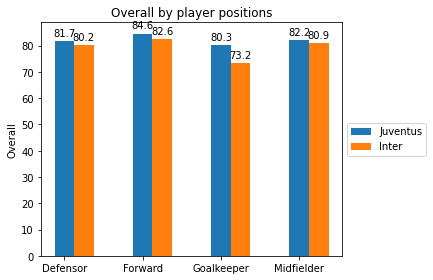

In [33]:
def dynamic_comparisons(): 
  list_teams = []
  w = widgets.SelectMultiple(
      options=clubs_top_20,

      #rows=len(clubs_top_20),
      description='Clubs',
      disabled=False
  )
  button_click=False
  #def dropdown_eventhandler(change):
    #print(change['new'])
  #  time.sleep(1)

  def on_button_clicked(b):
    #time.sleep(1)
    button_click = True
    if button_click:
      print("You have chosen these teams: ")
      list_teams = list(w.value)
      print('---'.join(team for team in list_teams))
      if len(list_teams)>3:
        print("-"*20)
        print(" TOO MUCH CHOICES!")
        return
      chart_with_comparisons(list_teams)

  def exit(b):
    button_click = True
    if button_click:
      w.close()
      button.close()
      clear_output()
      print("I'm closing...")
      time.sleep(1)
      clear_output()
    
  print("Choose 2 or 3 teams to compare their positions values")
  button = widgets.Button(description="Ok!")
  button_exit = widgets.Button(description="Exit")

  display(w)
  display(button)
  display(button_exit)

  button.on_click(on_button_clicked)
  button_exit.on_click(exit)

dynamic_comparisons()

In [ ]:
def static_interaction():
  dic_user = {1: one, 2:two, 3:three, 4:four, 5:five}
  print("Welcome to FIFA statistics! these are the 20 top club"+
        ", want do you want to see?")
  boiler_printings()
  print("-"*20)
  exit = False
  while(not exit):
    print("-"*20)
    choose = input("choose your statistic with the relative number: ")
    print("-"*20)
    if choose.isdigit():
      if choose  in dic_user.keys():
        dic_user[int(choose)]()
    elif choose.lower()=='exit' or choose.lower()=='no' or choose.lower() == "i'm bored":
        clear_output()
        print("I'm closing...")
        time.sleep(1)
        clear_output()
        exit = True
        break
    elif isinstance(float(choose), float):
      dic_user[int(choose[:1])](choose)
    else:
      print("\t\t | WRONG INPUT |")
    print("-"*20)
    boiler_printings()

static_interaction()

Welcome to FIFA statistics! these are the 20 top club, want do you want to see?
In this pre-anticipated release you can see:
1: Leaderboard of 20 top club
2: Leaderboard of 20 club if they had reached their max potential
3: Age average
4: most loyal players of clubs
5: chart of:
	-5.1: Defense
	-5.2: Forward
	-5.3: Goalkeeper
	-5.4: Midfield
write 'exit' or 'no' or 'i'm bored' when you want to exit
--------------------
--------------------
--------------------
